In [182]:
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.cluster import MiniBatchKMeans
from basic_functions import *

In [176]:
#Initial conditions of system
params_fixed = {
    "sigma": 10,
    "beta": 8/3,
    "rho": 28,
    "length": int(1e05),
    "dt": .005,
    "y0": jnp.array((1., 1., 1.)).flatten()
}

subset_size = 100

#REAL trajectory
ys = Euler(params_fixed)
Xtrain = ys.transpose()
sample_centers = MiniBatchKMeans(n_clusters=subset_size).fit(Xtrain).cluster_centers_
tree = cKDTree(sample_centers)
point_dst, point_idxs = tree.query(Xtrain)


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


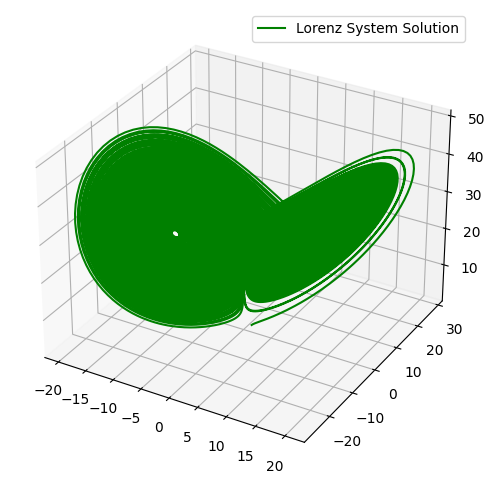

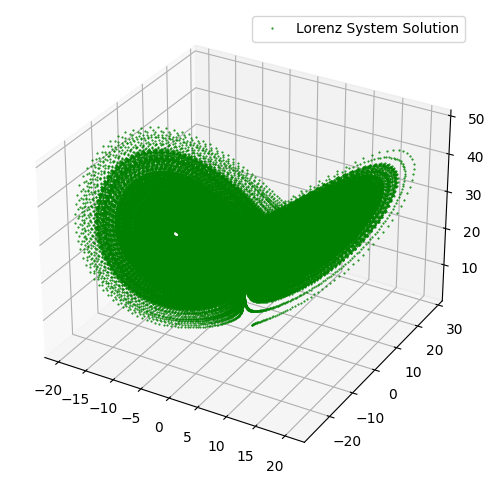

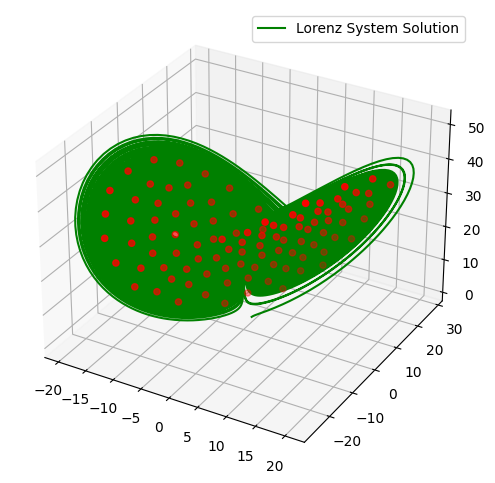

In [177]:
# Visualise Lorenz System Trajectory
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot(ys[0, :], ys[1, :], ys[2, :], label='Lorenz System Solution', color='g')
ax.legend()

plt.show()

# Visualise Lorenz System Trajectory as points
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot(ys[0, :], ys[1, :], ys[2, :], '.', markersize=1, label='Lorenz System Solution', color='g')  # Use '.' marker style
ax.legend()

plt.show()

# Add cell centers to Lorenz System Trajectory
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot(ys[0, :], ys[1, :], ys[2, :], label='Lorenz System Solution', color='g')
ax.legend()
ysample = sample_centers.transpose()
ax.scatter(ysample[0, :], ysample[1, :], ysample[2, :], label='Lorenz Cell Centers', color='r')

plt.show()

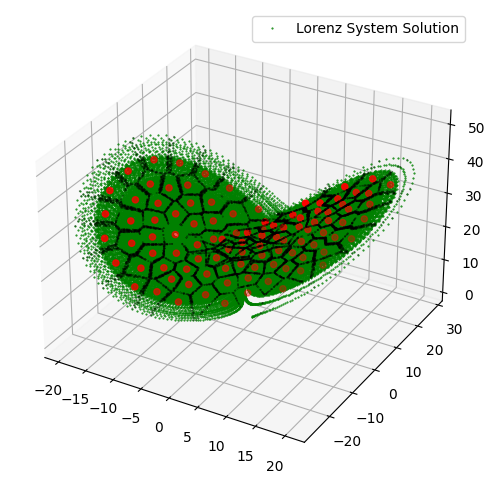

In [178]:
def get_bin_info(sample, nt = 1):
    # Compute transition matrix and visualize cell edges
    bins = [[] for _ in range(subset_size)]# Find the nearest cluster center for each solution point and assign them to corresponding bins

    for i in range(len(point_idxs)):
        bins[point_idxs[i]].append(i)

    # Calculate movement of each point based on timestep
    lp = len(point_idxs)
    transitions = point_idxs[nt:lp] - point_idxs[0:(lp - nt)]
    cellEdge = np.flatnonzero(transitions) + 1

    return cellEdge

nt = 1 # Timestep of movement
cellEdge = get_bin_info(sample_centers)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot(ys[0, :], ys[1, :], ys[2, :], '.', markersize=1, label='Lorenz System Solution', color='g')
ax.legend()
ysample = sample_centers.transpose()
ax.scatter(ysample[0, :], ysample[1, :], ysample[2, :], label='Lorenz Cell Centers', color='r')
ax.scatter(ys[0, cellEdge], ys[1, cellEdge], ys[2, cellEdge], label='Lorenz Cell Edges', color='k', s=0.05, alpha=0.75)
# ax.scatter(ys[0,cellEdge+1],ys[1,cellEdge+1],ys[2,cellEdge+1],label='Lorenz Cell Edges', color ='w',s=0.05,alpha=0.75)

plt.show()

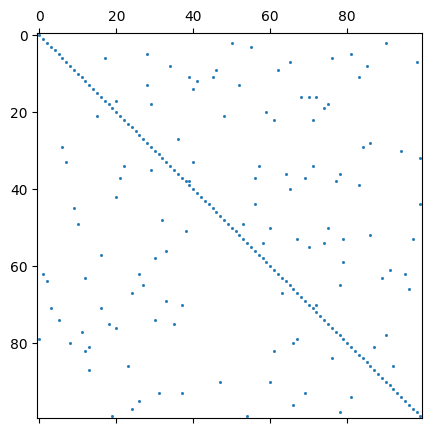

In [179]:
def find_markov_matrix(point_idxs, cellEdge):
    mat = np.zeros((subset_size, subset_size))
    for ind in range(0, len(cellEdge) - nt):
        ce = cellEdge[ind] #point_idxs[ce] : which cell the point is in after transition
        mat[point_idxs[ce+nt], point_idxs[ce]] += 1.0
        
    # Divide each column by the sum of that column
    column_sums = np.sum(mat, axis=0)

    for i in range(subset_size):
        if column_sums[i]:
            mat[:,i] = mat[:,i]/column_sums[i]
        else:
            mat[:,i] = 0.0
    return mat


M_mat = find_markov_matrix(point_idxs, cellEdge)
fig = plt.figure(figsize=(5, 5))
plt.spy(M_mat, precision=0, marker=None, markersize=1, aspect='equal', origin='upper')


In [180]:
def power_method(mat, threshhold=1e-6, max_iterations=10000):
    x_prev = np.ones(subset_size)

    for _ in range(max_iterations):
        x = np.dot(mat, x_prev)
        x /= np.sum(x)

        # Check convergence
        if np.linalg.norm(x - x_prev) < threshhold:
            break
        x_prev = x.copy()
    x /= np.sum(x)
    return x

#teleportation regularization
def teleportation_regularization(mat, alpha = .85):
    ones = np.ones(subset_size)
    
    regularization_term = alpha * (1 / subset_size) * np.outer(ones, ones)
    mat_regularized = (1 - alpha) * mat + regularization_term
    
    return mat_regularized

#Power method + teleportation regularization
#have markov matrix. depending on quality of data, we can use different methods. 
#for example, if sparse data (need to figure out what sparse means here - what factors do we NEED and what can we go without) use only invariant measure, 
#otherwise can use multiple modes( 2nd, 3rd, etc eigenvector)

def find_invariant_measure(mat, alpha=0.85, threshhold=1e-6, max_iterations=10000):
    mat_regularized = teleportation_regularization(mat, alpha)
    invariant_measure = power_method(mat_regularized, threshhold, max_iterations)
    return invariant_measure

# Extends invariant measure to fit total num of points
def extend_invariant_measure(vector):
    extended = []
    for ind in point_idxs:
        extended.append(vector[int(ind)])

    return extended

regularized_mat = teleportation_regularization(M_mat)
invariant_measure = power_method(regularized_mat)
extended_invariant_measure = extend_invariant_measure(invariant_measure)

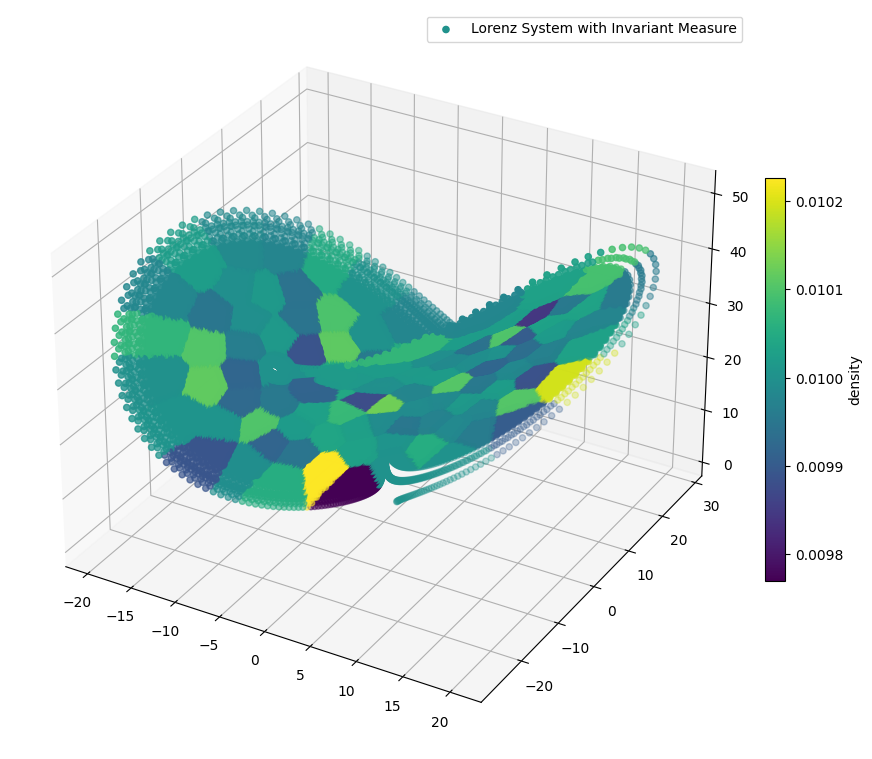

In [181]:
#plot the invariant measure approximated by power method
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ysample = sample_centers.transpose() #Unsure about why we transpose here
#ax.scatter(ysample[0, :], ysample[1, :], ysample[2, :], label='Lorenz Cell Centers', c = "r")
#ax.scatter(ys[0, cellEdge], ys[1, cellEdge], ys[2, cellEdge], label='Lorenz Cell Edges', color='k', s=0.05, alpha=0.75)
sc = ax.scatter(ys[0,:],ys[1,:],ys[2,:],label = "Lorenz System with Invariant Measure", c = extended_invariant_measure)
ax.legend()
cbar = fig.colorbar(sc,fraction=0.026, pad=0.02)
cbar.set_label("density")
plt.show()